In [145]:
from fastapi import FastAPI, File, UploadFile, HTTPException, Depends
from fastapi.responses import JSONResponse
from typing import List
import shutil
import os
from langchain_milvus import Milvus
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_milvus import Milvus
from langchain_community.tools import TavilySearchResults
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.state import CompiledStateGraph
from pydantic import BaseModel
from typing import Optional
from langchain_docling import DoclingLoader
from langchain_docling.loader import ExportType
from docling.chunking import HybridChunker
from contextlib import asynccontextmanager
from models import UploadResponse, DeleteResponse, ChatRequest, ChatResponse
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
import aiosqlite
from langchain.schema import HumanMessage, AIMessage, SystemMessage

In [146]:
import os

os.environ["GROQ_API_KEY"] = "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"
os.environ["TAVILY_API_KEY"] = "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"

In [148]:

llm = ChatGroq(temperature=0, model_name="mixtral-8x7b-32768")

vector_store = Milvus(
    embedding_function=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2"),
    connection_args={"uri": "./milvus_example.db"},
    index_params={"index_type": "FLAT", "metric_type": "L2"},
    auto_id=True
)

web_search = TavilySearchResults(
    max_results=1,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True
)

class ChatState(MessagesState):
    use_rag: bool = False
    use_web_search: bool = False
    rag_context: str = ""
    web_context: str = ""

def router(state: ChatState):
    use_rag = state["use_rag"]
    use_web_search = state["use_web_search"]
    if use_rag and use_web_search:
        return ["rag_node", "web_search_node"]
    elif use_rag:
        return ["rag_node"]
    if use_web_search:
        return ["web_search_node"]
    else:
        return ["llm_node"]
        
def rag_node(state: ChatState):
    """Retrieve context from vector database."""
    query = state["messages"][-1].content
    context = vector_store.similarity_search(query, k=3)
    context = "\n".join([doc.page_content for doc in context])
    return {"rag_context": context}
    
def web_search_node(state: ChatState):
    """Retrieve context from web search."""
    query = state["messages"][-1].content
    context = web_search.run(query)[0]['content']
    return {"web_context": context}


def llm_node(state: ChatState):
    """Generate response using LLM while maintaining conversation history."""
    print(state)
    if state["rag_context"]:
        state["messages"].append(SystemMessage(f"RAG Context: {state['rag_context']}"))
    if state["web_context"]:
        state["messages"].append(SystemMessage(f"Web Context: {state['web_context']}"))
    response = llm.invoke(state["messages"])
    # Update message history with response:
    return {"messages": [response]}

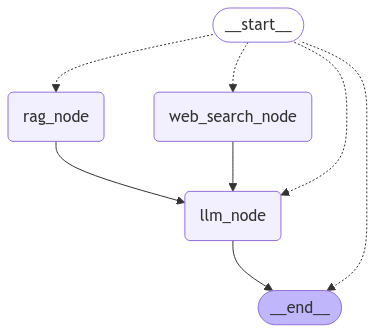

In [149]:
conn = sqlite3.connect("checkpoints.sqlite", check_same_thread=False)
memory = SqliteSaver(conn)

graph = StateGraph(ChatState)
graph.add_node("rag_node", rag_node)
graph.add_node("web_search_node", web_search_node)
graph.add_node("llm_node", llm_node)
# Define edges
graph.add_conditional_edges(START, router)
graph.add_edge("rag_node", "llm_node")
graph.add_edge("web_search_node", "llm_node")
graph.add_edge("llm_node", END)
cgraph = graph.compile(checkpointer=memory)
cgraph

In [150]:
input_messages = [HumanMessage("Hi")]
input_messages[-1].content

'Hi'

In [151]:
input_messages = [HumanMessage("Who is the current chief minister of delhi?")]
state = ChatState(use_rag=False, use_web_search=True, messages=input_messages, rag_context="", web_context="")
state

{'use_rag': False,
 'use_web_search': True,
 'messages': [HumanMessage(content='Who is the current chief minister of delhi?', additional_kwargs={}, response_metadata={})],
 'rag_context': '',
 'web_context': ''}

In [152]:
config = {"configurable": {"thread_id": "1"}}
output = cgraph.invoke(input=state, config=config)

{'messages': [HumanMessage(content='Who is the current chief minister of delhi?', additional_kwargs={}, response_metadata={}, id='9028a7bf-43ad-4632-a84d-0259db227f96')], 'use_rag': False, 'use_web_search': True, 'rag_context': '', 'web_context': "Delhi CM List: Chief Ministers of Delhi Party Names and Tenure till 2024 Following that, elections are held every five years to elect Delhi's Chief Minister. The current Chief Minister of New Delhi was Shri Arvind Kejriwal, who resigned from his position on September 15, 2024. List of Chief Minister of Delhi with Party Name and Work Duration Here is a list of Delhi's Chief Ministers, along with their party names and terms in office. He became the Chief Minister of Delhi on December 2, 1993, serving until February 26, 1996. Reiterating the AAP's call for early elections in Delhi, party leader Gopal Rai said Tuesday that Atishi will serve as chief minister until Arvind Kejriwal is re-elected with a large majority."}


In [153]:
output

{'messages': [HumanMessage(content='Who is the current chief minister of delhi?', additional_kwargs={}, response_metadata={}, id='9028a7bf-43ad-4632-a84d-0259db227f96'),
  SystemMessage(content="Web Context: Delhi CM List: Chief Ministers of Delhi Party Names and Tenure till 2024 Following that, elections are held every five years to elect Delhi's Chief Minister. The current Chief Minister of New Delhi was Shri Arvind Kejriwal, who resigned from his position on September 15, 2024. List of Chief Minister of Delhi with Party Name and Work Duration Here is a list of Delhi's Chief Ministers, along with their party names and terms in office. He became the Chief Minister of Delhi on December 2, 1993, serving until February 26, 1996. Reiterating the AAP's call for early elections in Delhi, party leader Gopal Rai said Tuesday that Atishi will serve as chief minister until Arvind Kejriwal is re-elected with a large majority.", additional_kwargs={}, response_metadata={}, id='77edfb33-14e5-4762-8

In [115]:
input_messages = [HumanMessage("who are the two people you named?")]
state = ChatState(use_rag=False, use_web_search=False, messages=input_messages, rag_context="", web_context="")
state

{'use_rag': False,
 'use_web_search': False,
 'messages': [HumanMessage(content='who are the two people you named?', additional_kwargs={}, response_metadata={})],
 'rag_context': '',
 'web_context': ''}

In [116]:
config = {"configurable": {"thread_id": "1"}}
output = cgraph.invoke(input=state, config=config)

{'messages': [HumanMessage(content='Who is the current chief minister of delhi?', additional_kwargs={}, response_metadata={}, id='e3ff6d5c-a04e-4d4b-9a46-19587f69a623'), SystemMessage(content="Web Context: Delhi CM Name Announcement: The Bharatiya Janata Party elected MLA Rekha Gupta as the next chief minister of Delhi in a Legislature Party meeting today. The party has come to power in the national capital after a gap of 27 years. Virendra Sachdeva, BJP's Delhi unit chief, is said to have visited the iconic Ramlila Maidan on Tuesday to monitor the preparations.", additional_kwargs={}, response_metadata={}, id='99a6eac0-aa94-4505-811f-64db108bf125'), AIMessage(content='As of the information provided in the web context, the current chief minister of Delhi is Arvind Kejriwal, who is a member of the Aam Aadmi Party (AAP). However, the context states that the Bharatiya Janata Party (BJP) has elected Rekha Gupta as the next chief minister of Delhi. This suggests that there will be a change 

In [117]:
output

{'messages': [HumanMessage(content='Who is the current chief minister of delhi?', additional_kwargs={}, response_metadata={}, id='e3ff6d5c-a04e-4d4b-9a46-19587f69a623'),
  SystemMessage(content="Web Context: Delhi CM Name Announcement: The Bharatiya Janata Party elected MLA Rekha Gupta as the next chief minister of Delhi in a Legislature Party meeting today. The party has come to power in the national capital after a gap of 27 years. Virendra Sachdeva, BJP's Delhi unit chief, is said to have visited the iconic Ramlila Maidan on Tuesday to monitor the preparations.", additional_kwargs={}, response_metadata={}, id='99a6eac0-aa94-4505-811f-64db108bf125'),
  AIMessage(content='As of the information provided in the web context, the current chief minister of Delhi is Arvind Kejriwal, who is a member of the Aam Aadmi Party (AAP). However, the context states that the Bharatiya Janata Party (BJP) has elected Rekha Gupta as the next chief minister of Delhi. This suggests that there will be a cha

In [118]:
input_messages = [HumanMessage("whom should i vote for?")]
state = ChatState(use_rag=False, use_web_search=False, messages=input_messages, rag_context="", web_context="")
state

{'use_rag': False,
 'use_web_search': False,
 'messages': [HumanMessage(content='whom should i vote for?', additional_kwargs={}, response_metadata={})],
 'rag_context': '',
 'web_context': ''}

In [119]:
config = {"configurable": {"thread_id": "1"}}
output = cgraph.invoke(input=state, config=config)

{'messages': [HumanMessage(content='Who is the current chief minister of delhi?', additional_kwargs={}, response_metadata={}, id='e3ff6d5c-a04e-4d4b-9a46-19587f69a623'), SystemMessage(content="Web Context: Delhi CM Name Announcement: The Bharatiya Janata Party elected MLA Rekha Gupta as the next chief minister of Delhi in a Legislature Party meeting today. The party has come to power in the national capital after a gap of 27 years. Virendra Sachdeva, BJP's Delhi unit chief, is said to have visited the iconic Ramlila Maidan on Tuesday to monitor the preparations.", additional_kwargs={}, response_metadata={}, id='99a6eac0-aa94-4505-811f-64db108bf125'), AIMessage(content='As of the information provided in the web context, the current chief minister of Delhi is Arvind Kejriwal, who is a member of the Aam Aadmi Party (AAP). However, the context states that the Bharatiya Janata Party (BJP) has elected Rekha Gupta as the next chief minister of Delhi. This suggests that there will be a change 

In [132]:
output

{'messages': [HumanMessage(content='Who is the current chief minister of delhi?', additional_kwargs={}, response_metadata={}, id='e3ff6d5c-a04e-4d4b-9a46-19587f69a623'),
  SystemMessage(content="Web Context: Delhi CM Name Announcement: The Bharatiya Janata Party elected MLA Rekha Gupta as the next chief minister of Delhi in a Legislature Party meeting today. The party has come to power in the national capital after a gap of 27 years. Virendra Sachdeva, BJP's Delhi unit chief, is said to have visited the iconic Ramlila Maidan on Tuesday to monitor the preparations.", additional_kwargs={}, response_metadata={}, id='99a6eac0-aa94-4505-811f-64db108bf125'),
  AIMessage(content='As of the information provided in the web context, the current chief minister of Delhi is Arvind Kejriwal, who is a member of the Aam Aadmi Party (AAP). However, the context states that the Bharatiya Janata Party (BJP) has elected Rekha Gupta as the next chief minister of Delhi. This suggests that there will be a cha

In [144]:
import langchain_core

l = [(type(message), message.content) for message in cgraph.get_state(config).values["messages"]]

for item in l:
    if item[0] == HumanMessage:
        print(f"HUMAN: \n{item[1]}\n")
    elif item[0] == AIMessage:
        print(f"AI: \n{item[1]}\n")
    elif item[0] == SystemMessage:
        print(f"SYSTEM: \n{item[1]}\n")

HUMAN: 
Who is the current chief minister of delhi?

SYSTEM: 
Web Context: Delhi CM Name Announcement: The Bharatiya Janata Party elected MLA Rekha Gupta as the next chief minister of Delhi in a Legislature Party meeting today. The party has come to power in the national capital after a gap of 27 years. Virendra Sachdeva, BJP's Delhi unit chief, is said to have visited the iconic Ramlila Maidan on Tuesday to monitor the preparations.

AI: 
As of the information provided in the web context, the current chief minister of Delhi is Arvind Kejriwal, who is a member of the Aam Aadmi Party (AAP). However, the context states that the Bharatiya Janata Party (BJP) has elected Rekha Gupta as the next chief minister of Delhi. This suggests that there will be a change in the chief minister of Delhi, and Rekha Gupta will take over the position from Arvind Kejriwal. It is important to note that this information is based on the web context provided and may not be up-to-date or accurate. It is always a

In [133]:
{type(message): message.content for message in cgraph.get_state(config).values["messages"]}

{langchain_core.messages.human.HumanMessage: 'whom should i vote for?',
 langchain_core.messages.system.SystemMessage: "Web Context: Delhi CM Name Announcement: The Bharatiya Janata Party elected MLA Rekha Gupta as the next chief minister of Delhi in a Legislature Party meeting today. The party has come to power in the national capital after a gap of 27 years. Virendra Sachdeva, BJP's Delhi unit chief, is said to have visited the iconic Ramlila Maidan on Tuesday to monitor the preparations.",
 langchain_core.messages.ai.AIMessage: "I am an artificial intelligence language model and do not have personal opinions or the ability to vote. It is up to each individual to make their own decision about who to vote for based on their own values, beliefs, and research.\n\nWhen deciding who to vote for, it can be helpful to consider the following factors:\n\n* The candidate's stance on issues that are important to you\n* The candidate's experience and qualifications\n* The candidate's track recor